# Master Thesis - Vignoli Lorenzo

---

## 🐙 Helyx training

## ⚙️ Import Libraries

In [1]:
# Libraries
import os
import glob
import random
import warnings
import numpy as np # type: ignore
from PIL import Image # type: ignore
from datetime import datetime
from sklearn.model_selection import train_test_split # type: ignore

import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from torchvision import models, transforms # type: ignore
import torch.nn.functional as F # type: ignore
import shutil
import plotly.graph_objects as go # type: ignore
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR, ReduceLROnPlateau # type: ignore

import matplotlib.pyplot as plt # type: ignore
import random
import sys
from torch.amp import GradScaler, autocast # type: ignore

warnings.filterwarnings("ignore")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## ⏳ Load and process the Data

In [ ]:
if True:

    # Remove existing folders
    for split in ["train", "val", "test"]:
        shutil.rmtree(f"images/{split}", ignore_errors=True)
        shutil.rmtree(f"labels/{split}", ignore_errors=True)
        shutil.rmtree(f"DELTAL/{split}", ignore_errors=True)
        os.makedirs(f"images/{split}", exist_ok=True)
        os.makedirs(f"labels/{split}", exist_ok=True)
        os.makedirs(f"DELTAL/{split}", exist_ok=True)

    # Load all .pt datasets
    dataset_files = sorted(glob.glob("Dataset*.pt"))

    # Compute total number of samples
    total_originals = sum([len(torch.load(f)["X_images"]) for f in dataset_files])
    all_indices = np.arange(total_originals)

    # Split train, validation, test (80-10-5 %)
    train_idx, temp_idx = train_test_split(all_indices, test_size=0.15, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, random_state=seed)

    split_map = np.full(total_originals, "", dtype=object)
    split_map[train_idx] = "train"
    split_map[val_idx] = "val"
    split_map[test_idx] = "test"

    global_index = {
        "train": 0,
        "val": 0,
        "test": 0
    }

    current_idx = 0

    for file in dataset_files:

        print(f"\n Processing {file}...")
        data = torch.load(file)
        X_images = data["X_images"]
        y = data["y"]
        X_DELTAL = data["X_DELTAL"]

        for i in range(len(X_images)):

            split = split_map[current_idx]
            assert split in {"train", "val", "test"}

            image_tensor = X_images[i]
            label_tensor = y[i]
            deltal_tensor = X_DELTAL[i]

            idx_str = f"{global_index[split]:06d}"
            torch.save(image_tensor, f"images/{split}/img_{idx_str}.pt")
            torch.save(label_tensor, f"labels/{split}/label_{idx_str}.pt")
            torch.save(deltal_tensor, f"DELTAL/{split}/deltal_{idx_str}.pt")
            global_index[split] = global_index[split] + 1

            current_idx += 1
            percent = (current_idx / total_originals) * 100
            sys.stdout.write(f"\rProgress: {percent:.2f}%")
            sys.stdout.flush()

        del X_images
        del y
        del X_DELTAL

    print("\n Finished dataset generation.")

In [3]:
if True:
    label_paths = sorted(glob.glob("labels/train/*.pt"))
    all_labels = torch.stack([torch.load(p).float() for p in label_paths])
    mean = all_labels.mean(dim=0)
    std = all_labels.std(dim=0)
    torch.save({'mean': mean, 'std': std}, 'label_stats.pt')

    del mean, std

In [4]:
class ImageRegressionDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image = torch.load(self.image_paths[idx]).float()   # [C, H, W] in [0, 255]
        label = torch.load(self.label_paths[idx]).float()   # [6]

        return image, label

In [ ]:
# Load sorted image and label paths
def get_paths(split):
    image_dir = os.path.join("images", split)
    label_dir = os.path.join("labels", split)
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".pt")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".pt")])
    assert len(image_paths) == len(label_paths)
    return image_paths, label_paths

# Get paths for each split
train_img, train_lbl = get_paths("train")
val_img, val_lbl = get_paths("val")
test_img, test_lbl = get_paths("test")

# Dataset dimensions
print(f"Processed: \n {len(train_img)} training images \n {len(val_img)} validation images \n {len(test_img)} test images")

# Create datasets
train_dataset = ImageRegressionDataset(train_img, train_lbl)
val_dataset = ImageRegressionDataset(val_img, val_lbl)
test_dataset = ImageRegressionDataset(test_img, test_lbl)

# Create dataloaders (ottimizzati)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=12, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        num_workers=12, pin_memory=True, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         num_workers=12, pin_memory=True, persistent_workers=True)


Processed: 
 10 training images 
 10 validation images 
 10 test images


## ⚓ Network definition

In [6]:
class Markers(nn.Module):
    def __init__(self):
        super().__init__()

    def rgb_to_hsv(self, x):
        r, g, b = x[:, 0], x[:, 1], x[:, 2]
        maxc, _ = x.max(dim=1)
        minc, _ = x.min(dim=1)
        v = maxc
        eps = 1e-8

        deltac = maxc - minc
        s = deltac / (maxc + eps)
        s[maxc == 0] = 0

        rc = (maxc - r) / (deltac + eps)
        gc = (maxc - g) / (deltac + eps)
        bc = (maxc - b) / (deltac + eps)

        h = torch.zeros_like(maxc)
        h[maxc == r] = (bc - gc)[maxc == r]
        h[maxc == g] = 2.0 + (rc - bc)[maxc == g]
        h[maxc == b] = 4.0 + (gc - rc)[maxc == b]
        h = (h / 6.0) % 1.0
        h[deltac == 0] = 0.0

        return torch.stack([h, s, v], dim=1)

    def forward(self, x):
        hsv = self.rgb_to_hsv(x)
        h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

        green = ((h > 0.25) & (h < 0.45) & (s > 0.3) & (v > 0.2)).unsqueeze(1).float()
        black = (v < 0.3).unsqueeze(1).float()

        return torch.cat([black, green], dim=1)     # if 2 markers

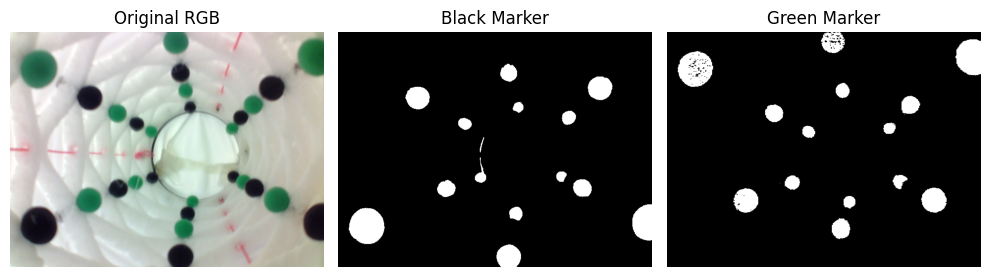

In [7]:
# Load a random image
paths = sorted(glob.glob("images/train/*.pt"))
path = random.choice(paths)
image = torch.load(path).float() / 255  # [3, H, W]

# Apply markers
markers = Markers()
filtered = markers(image.unsqueeze(0))[0]  # [2, H, W]

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow((image*255).permute(1, 2, 0).byte())
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(filtered[0].cpu(), cmap="gray")
plt.title("Black Marker")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(filtered[1].cpu(), cmap="gray")
plt.title("Green Marker")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stack=1, dropout=True):
        super().__init__()
        layers = []
        for i in range(stack):
            if i == 0:
                conv_in = in_channels
            else:
                conv_in = out_channels
            layers.append(nn.Conv2d(conv_in, out_channels, kernel_size=kernel_size, padding=kernel_size // 2))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            if dropout:
                layers.append(nn.Dropout2d(0.025))
        self.blocks = nn.Sequential(*layers)

        self.skip_adjust = nn.Identity()
        if in_channels != out_channels:
            self.skip_adjust = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip_adjust(x)
        out = self.blocks(x)
        out += identity
        return F.relu(out, inplace=True)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.res = ResidualBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            diff_h = skip.shape[-2] - x.shape[-2]
            diff_w = skip.shape[-1] - x.shape[-1]
            skip = skip[:, :, diff_h // 2: diff_h // 2 + x.shape[-2],
                              diff_w // 2: diff_w // 2 + x.shape[-1]]
        x = torch.cat([x, skip], dim=1)
        return self.res(x)

In [9]:
class NetCamera(nn.Module):
    def __init__(self):
        super().__init__()

        self.markers = Markers()

        self.enc1 = ResidualBlock(2, 12, stack=2)
        self.enc2 = ResidualBlock(12, 24, stack=2)
        self.enc3 = ResidualBlock(24, 48, stack=2)
        self.enc4 = ResidualBlock(48, 96, stack=2)
        self.enc5 = ResidualBlock(96, 144, stack=2)
        self.enc6 = ResidualBlock(144, 192, stack=2)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ResidualBlock(192, 256, stack=2)

        self.dec1 = DecoderBlock(256, 192, 192)
        self.dec2 = DecoderBlock(192, 144, 144)
        self.dec3 = DecoderBlock(144, 96, 96)
        self.dec4 = DecoderBlock(96, 48, 48)
        self.dec5 = DecoderBlock(48, 24, 24)
        self.dec6 = DecoderBlock(24, 12, 12)

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((15, 20)),
            nn.Flatten(),
            nn.Linear(12 * 15 * 20, 128),  # assuming input 480×640 and 6 downsamplings
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )

    def forward(self, x):
        x = x / 255.0
        x = self.markers(x)

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x5 = self.enc5(self.pool(x4))
        x6 = self.enc6(self.pool(x5))

        x = self.bottleneck(self.pool(x6))

        x = self.dec1(x, x6)
        x = self.dec2(x, x5)
        x = self.dec3(x, x4)
        x = self.dec4(x, x3)
        x = self.dec5(x, x2)
        x = self.dec6(x, x1)
        x = self.fc(x)
        return x

## 😓 Training

In [10]:
model = NetCamera().to(device)

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

# Learning rate management
scheduler = LinearLR(optimizer, start_factor = 1e-3, end_factor = 1.0, total_iters = 5)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.8, patience=10, verbose=True)

Total trainable parameters: 4,330,082


In [11]:
best_val_loss = float('inf')
patience = 30
counter = 0

# Normalization parameters
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)

In [12]:
# Histories
history_train = []
history_val = []

# Scaler for efficiency
scaler = GradScaler(device='cuda')

for epoch in range(200):
    model.train()
    train_losses = []
    total_batches = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            labels_norm = (labels - mean) / std
            preds = model(images)
            loss = criterion(preds, labels_norm)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

        progress = (i + 1) / total_batches * 100
        sys.stdout.write(f"\rEpoch {epoch + 1}: {progress:.1f}%")
        sys.stdout.flush()

    # Validation
    model.eval()
    val_losses = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            with autocast(device_type='cuda'):
                labels_norm = (labels - mean) / std
                preds = model(images)
                loss = criterion(preds, labels_norm)

            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step()
    plateau_scheduler.step(avg_val_loss)
    history_train.append(avg_train_loss)
    history_val.append(avg_val_loss)

    # Summary
    sys.stdout.write("\r")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "helyx_model_normalized.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

del model
del stats

Epoch 1 | Train Loss: 0.6119 | Val Loss: 0.5701 | LR: 0.000201
Epoch 2 | Train Loss: 0.6127 | Val Loss: 0.5430 | LR: 0.000401
Epoch 3 | Train Loss: 0.4388 | Val Loss: 0.5177 | LR: 0.000600
Epoch 4 | Train Loss: 0.3116 | Val Loss: 0.4915 | LR: 0.000800
Epoch 5 | Train Loss: 0.2174 | Val Loss: 0.4715 | LR: 0.001000
Epoch 6 | Train Loss: 0.1547 | Val Loss: 0.4592 | LR: 0.001000
Epoch 7 | Train Loss: 0.1390 | Val Loss: 0.4515 | LR: 0.001000
Epoch 8 | Train Loss: 0.1123 | Val Loss: 0.4411 | LR: 0.001000
Epoch 9 | Train Loss: 0.0982 | Val Loss: 0.4350 | LR: 0.001000
Epoch 10 | Train Loss: 0.0785 | Val Loss: 0.4252 | LR: 0.001000
Epoch 11 | Train Loss: 0.0689 | Val Loss: 0.4051 | LR: 0.001000
Epoch 12 | Train Loss: 0.0677 | Val Loss: 0.3910 | LR: 0.001000
Epoch 13 | Train Loss: 0.0547 | Val Loss: 0.3821 | LR: 0.001000
Epoch 14 | Train Loss: 0.0472 | Val Loss: 0.3792 | LR: 0.001000
Epoch 15 | Train Loss: 0.0512 | Val Loss: 0.3761 | LR: 0.001000
Epoch 16 | Train Loss: 0.0422 | Val Loss: 0.3697 

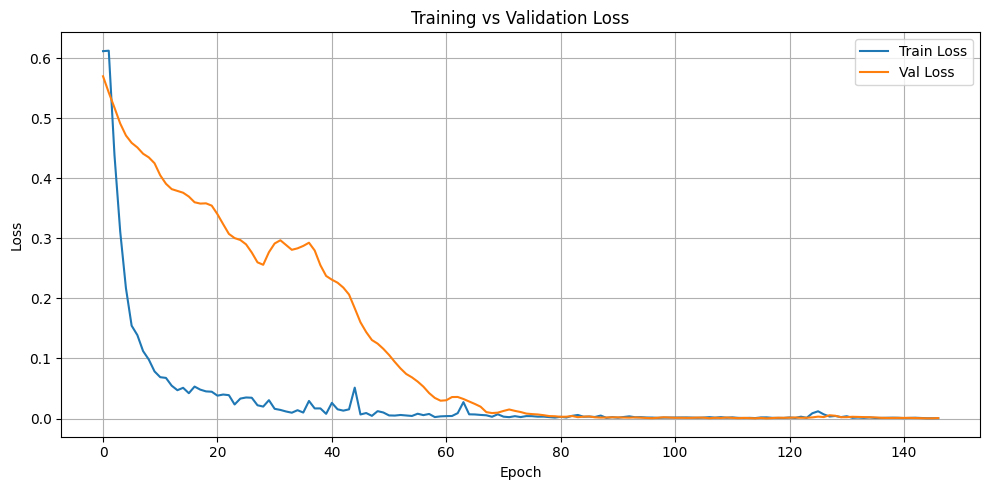

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history_train, label='Train Loss')
plt.plot(history_val, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
class DenormalizedModel(nn.Module):
    def __init__(self, base_model, mean, std):
        super().__init__()
        self.base_model = base_model
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        out = self.base_model(x)
        return out * self.std + self.mean

In [15]:
model = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")

# Model and parameters
model = model.to(device)
mean = stats['mean'].to(device)
std = stats['std'].to(device)

# Save final model
final_model = DenormalizedModel(model, mean, std)
torch.save(final_model, "helyx_model.pt")

del final_model
del stats

## ⏰ Testing



Test MSE - normalized: 0.0003
Test MSE: 0.0549


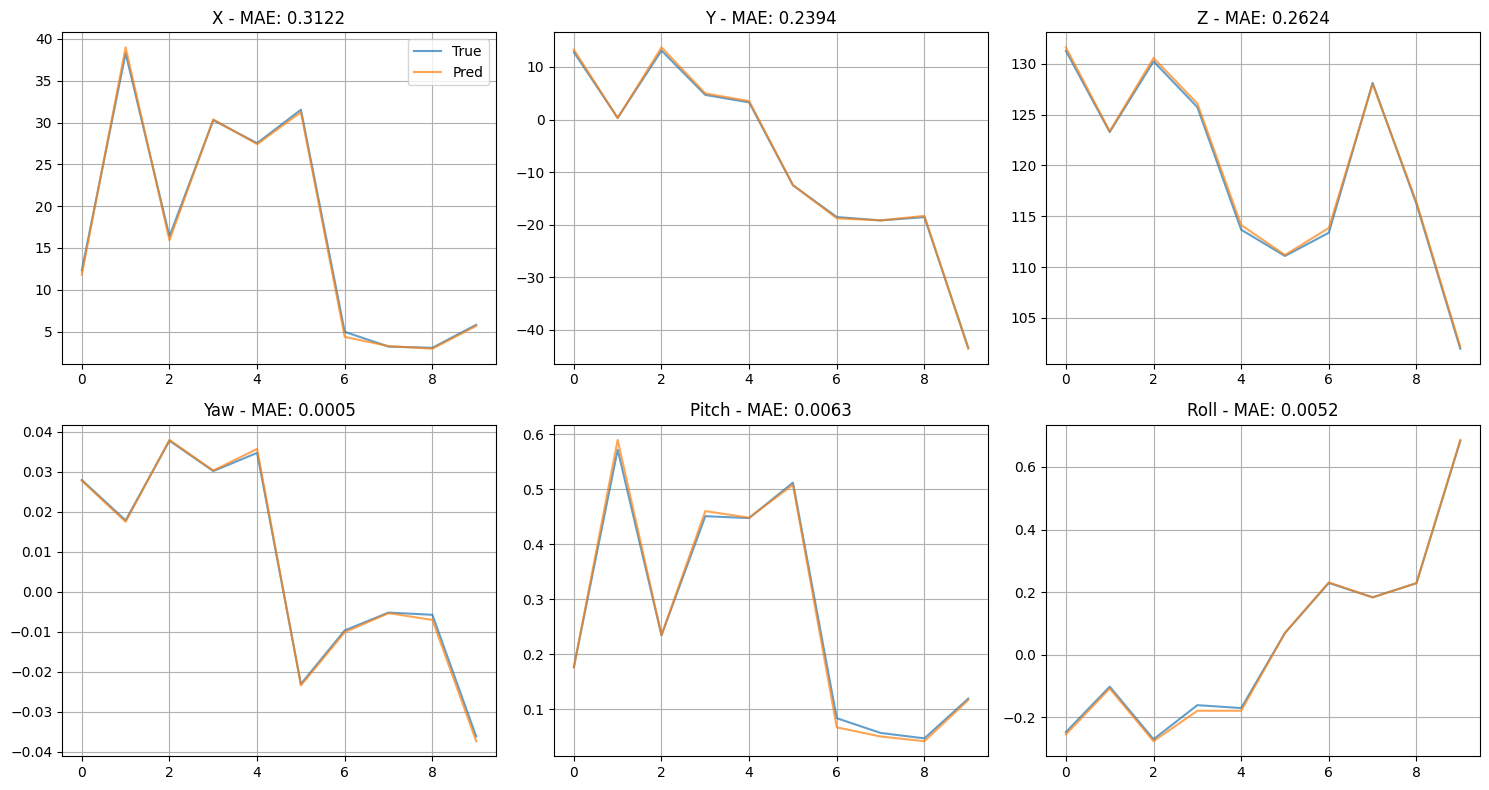

In [17]:
# Load full model
model = torch.load("helyx_model.pt")
model_normalized = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)
model = model.to(device)
model_normalized = model_normalized.to(device)
model.eval()
model_normalized.eval()

all_preds = []
all_preds_normalized = []
all_labels = []
all_labels_normalized = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_normalized = (labels - mean) / std

        preds = model(images)
        preds_normalized = model_normalized(images)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_preds_normalized.append(preds_normalized.cpu().numpy())
        all_labels_normalized.append(labels_normalized.cpu().numpy())
        del images, labels, preds, preds_normalized

print("\n")

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds_normalized = np.concatenate(all_preds_normalized, axis=0)
all_labels_normalized = np.concatenate(all_labels_normalized, axis=0)

mse = np.mean((all_preds - all_labels) ** 2)
mse_normalized = np.mean((all_preds_normalized - all_labels_normalized) ** 2)
print(f"Test MSE - normalized: {mse_normalized:.4f}")
print(f"Test MSE: {mse:.4f}")

param_names = ['X', 'Y', 'Z', 'Yaw', 'Pitch', 'Roll']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flatten()):
    mae = np.mean(np.abs(all_preds[:, i] - all_labels[:, i]))  # Calculate MAE
    ax.plot(all_labels[:, i], label='True', alpha=0.7)
    ax.plot(all_preds[:, i], label='Pred', alpha=0.7)
    ax.set_title(f"{param_names[i]} - MAE: {mae:.4f}")
    ax.grid(True)

axes[0, 0].legend()
plt.tight_layout()
plt.show()
